# QE reconstruction with Chile Wide for Litebird x S4

In [1]:
import os
import sys
import matplotlib as mpl
import matplotlib.pyplot as pl
import numpy as np
import healpy as hp 
from plancklens import utils
from plancklens import qresp
from scipy.interpolate import UnivariateSpline as spl


In [2]:
import sys
sys.version

'3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) \n[GCC 9.4.0]'

In [3]:

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['font.size'] = 20
# mpl.rcParams['figure.figsize'] = 6.4, 4.8
mpl.rcParams['figure.figsize'] = 8.5, 5.5

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('legend', fontsize=15)
mpl.rcParams['errorbar.capsize'] = 4

In [4]:
def w(ell):
    return (ell*(ell+1))**2 / 2 / np.pi * 1e7

def p2k(lmax):
    return 0.5 * np.arange(lmax + 1) * np.arange(1, lmax + 2, dtype=float)

In [5]:

# Import param file
module_path = os.path.abspath(os.path.join('../params'))
if module_path not in sys.path:
    sys.path.append(module_path)

import param_chwide_qe_lminB200 as param_file


Using lenspyx alm2map


In [6]:
# Import sims library 

module_path = os.path.abspath(os.path.join('../../20231018_signal_cmb'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import unlensed_ffp10

In [7]:
qlms_dd = param_file.qlms_dd

In [8]:
cmb_unl= unlensed_ffp10.cmb_unl_ffp10()

Input aberration power 2.126e-06


In [9]:
k = 'p_p'

In [10]:
# QE response
resp = param_file.qresp_dd.get_response('p_p', 'p')

In [11]:
plm0 = qlms_dd.get_sim_qlm(k, 0) 
hp.almxfl(plm0, utils.cli(resp), hp.Alm.getlmax(np.size(plm0)), True)


array([-0.00000000e+00+0.00000000e+00j,  7.10733358e-02+0.00000000e+00j,
        6.62646230e-03+0.00000000e+00j, ...,
       -6.41382295e-11-2.13621996e-11j, -6.18765516e-12-2.13414103e-11j,
       -7.71667939e-11+1.38744847e-11j])

In [12]:
# input lensing field
plm_in = utils.alm_copy(cmb_unl.get_sim_plm(0), lmax=hp.Alm.getlmax(np.size(plm0)))

In [13]:
# plm00 = hp.read_alm('/pscratch/sd/l/llegrand/lenscarfrecs/chwide/qlms_dd/sim_p_p_0000.fits')

In [14]:
# Produce the alms that will be used by Litebird group
nsims = 25

savedir = '/global/cfs/cdirs/cmbs4xlb/v1/lensingrec'
if not os.path.exists(os.path.join(savedir, 'chwide_qe_v1.1')):
    os.makedirs(os.path.join(savedir, 'chwide_qe_v1.1'))

fn = lambda idx: os.path.join(savedir, 'chwide_qe_v1.1', f'plm_resp_p_p_{idx:04}.fits')
                     
                     
for idx in np.arange(nsims):
    print(fn(idx))
    if not os.path.exists(fn(idx)):
        plm_i = qlms_dd.get_sim_qlm(k, idx)
        hp.almxfl(plm_i, utils.cli(resp), hp.Alm.getlmax(np.size(plm_i)), True)
        hp.write_alm(fn(idx), plm_i)


/global/cfs/cdirs/cmbs4xlb/v1/lensingrec/chwide_qe_v1.1/plm_resp_p_p_0000.fits
/global/cfs/cdirs/cmbs4xlb/v1/lensingrec/chwide_qe_v1.1/plm_resp_p_p_0001.fits
/global/cfs/cdirs/cmbs4xlb/v1/lensingrec/chwide_qe_v1.1/plm_resp_p_p_0002.fits
/global/cfs/cdirs/cmbs4xlb/v1/lensingrec/chwide_qe_v1.1/plm_resp_p_p_0003.fits
/global/cfs/cdirs/cmbs4xlb/v1/lensingrec/chwide_qe_v1.1/plm_resp_p_p_0004.fits
/global/cfs/cdirs/cmbs4xlb/v1/lensingrec/chwide_qe_v1.1/plm_resp_p_p_0005.fits
/global/cfs/cdirs/cmbs4xlb/v1/lensingrec/chwide_qe_v1.1/plm_resp_p_p_0006.fits
/global/cfs/cdirs/cmbs4xlb/v1/lensingrec/chwide_qe_v1.1/plm_resp_p_p_0007.fits
/global/cfs/cdirs/cmbs4xlb/v1/lensingrec/chwide_qe_v1.1/plm_resp_p_p_0008.fits
/global/cfs/cdirs/cmbs4xlb/v1/lensingrec/chwide_qe_v1.1/plm_resp_p_p_0009.fits
/global/cfs/cdirs/cmbs4xlb/v1/lensingrec/chwide_qe_v1.1/plm_resp_p_p_0010.fits
/global/cfs/cdirs/cmbs4xlb/v1/lensingrec/chwide_qe_v1.1/plm_resp_p_p_0011.fits
/global/cfs/cdirs/cmbs4xlb/v1/lensingrec/chwide_qe_v

In [16]:
# Save the response 
fn_resp = os.path.join(savedir, 'chwide_qe_v1.1', 'resp_qe.txt')
if not os.path.exists(fn_resp):
    resp_arr = np.array([np.arange(resp.shape[0]), resp])
    np.savetxt(fn_resp, resp_arr.T, header='Fiducial QE response\n L, Resp')

In [17]:
plm00 = hp.read_alm(fn(idx))

In [18]:
# Mean field estimate
mcsims = np.arange(1, 25)
plm_mf1 = np.zeros_like(plm0)
plm_mf2 = np.zeros_like(plm0)

for idx in mcsims[::2]:
    plm_mf1+= qlms_dd.get_sim_qlm(k, idx)   
plm_mf1 /= np.size(mcsims[::2])
hp.almxfl(plm_mf1, utils.cli(resp), hp.Alm.getlmax(np.size(plm_mf1)), True)


for idx in mcsims[1::2]:
    plm_mf2+= qlms_dd.get_sim_qlm(k, idx)   
plm_mf2 /= np.size(mcsims[::2])
hp.almxfl(plm_mf2, utils.cli(resp), hp.Alm.getlmax(np.size(plm_mf2)), True)


array([0.00000000e+00+0.00000000e+00j, 7.10041022e-02+0.00000000e+00j,
       6.70474216e-03+0.00000000e+00j, ...,
       6.46405279e-12-1.14916130e-11j, 2.47743308e-12+2.01621773e-11j,
       9.25009366e-12-1.19141509e-11j])

In [19]:
# Semi analytical N0 bias
n0_semi = param_file.nhl_dd.get_sim_nhl(0, k, k)
N0 = n0_semi * utils.cli(resp)**2

In [50]:
# Save all semi-analytical N0 biases
fn = lambda idx: os.path.join(savedir, 'chwide_qe_v1.1', f'Nlzero_semianalytic_{idx:04}.txt')                  
                     
for idx in np.arange(nsims):
    print(fn(idx))
    if not os.path.exists(fn(idx)):
        _n0_semi = param_file.nhl_dd.get_sim_nhl(0, k, k)
        _N0 = _n0_semi * utils.cli(resp)**2
        # hp.almxfl(plm_i, utils.cli(resp), hp.Alm.getlmax(np.size(plm_i)), True)
        _arr = np.array([np.arange(_N0.shape[0]), _N0])
        np.savetxt(fn(idx), _arr.T, header='N0 semi-analytical, normalized\n L, N0')


/global/cfs/cdirs/cmbs4xlb/v1/lensingrec/chwide_qe_v1.1/Nlzero_semianalytic_0000.txt
/global/cfs/cdirs/cmbs4xlb/v1/lensingrec/chwide_qe_v1.1/Nlzero_semianalytic_0001.txt
/global/cfs/cdirs/cmbs4xlb/v1/lensingrec/chwide_qe_v1.1/Nlzero_semianalytic_0002.txt
/global/cfs/cdirs/cmbs4xlb/v1/lensingrec/chwide_qe_v1.1/Nlzero_semianalytic_0003.txt
/global/cfs/cdirs/cmbs4xlb/v1/lensingrec/chwide_qe_v1.1/Nlzero_semianalytic_0004.txt
/global/cfs/cdirs/cmbs4xlb/v1/lensingrec/chwide_qe_v1.1/Nlzero_semianalytic_0005.txt
/global/cfs/cdirs/cmbs4xlb/v1/lensingrec/chwide_qe_v1.1/Nlzero_semianalytic_0006.txt
/global/cfs/cdirs/cmbs4xlb/v1/lensingrec/chwide_qe_v1.1/Nlzero_semianalytic_0007.txt
/global/cfs/cdirs/cmbs4xlb/v1/lensingrec/chwide_qe_v1.1/Nlzero_semianalytic_0008.txt
/global/cfs/cdirs/cmbs4xlb/v1/lensingrec/chwide_qe_v1.1/Nlzero_semianalytic_0009.txt
/global/cfs/cdirs/cmbs4xlb/v1/lensingrec/chwide_qe_v1.1/Nlzero_semianalytic_0010.txt
/global/cfs/cdirs/cmbs4xlb/v1/lensingrec/chwide_qe_v1.1/Nlzero_se

In [23]:
ftl = param_file.ivfs.get_ftl()
fel = param_file.ivfs.get_fel()
fbl = param_file.ivfs.get_fbl()

In [24]:
from lensitbiases import n1_fft
from lenspec import iterbiasesN0N1

In [25]:
cls_noise_fid = {
    'tt': (param_file.nlev_t / 180 / 60 * np.pi) ** 2 * utils.cli(param_file.transf_tlm ** 2),
    'ee': (param_file.nlev_p / 180 / 60 * np.pi) ** 2 * utils.cli(param_file.transf_elm ** 2),
    'bb': (param_file.nlev_p / 180 / 60 * np.pi) ** 2 * utils.cli(param_file.transf_blm ** 2),
}

fals, dat_cls, cls_w, cls_f = iterbiasesN0N1.get_fals(k, param_file.cls_weight, param_file.cls_grad, cls_noise_fid, cls_noise_fid, lmin_ivf=param_file.lmin_elm, lmax_ivf=param_file.lmax_ivf)


In [43]:
lmax_qlm = 4000
n1lib = n1_fft.n1_fft(fals, cls_w, cls_f, np.copy(param_file.cls_unl['pp']), lminbox=50, lmaxbox=5000, k2l=None)
n1_Ls = np.arange(50, (lmax_qlm // 50) * 50  + 50, 50)

n1 = np.array([n1lib.get_n1(k, L, do_n1mat=False) for L in n1_Ls])
N1 = spl(n1_Ls, n1_Ls ** 2 * (n1_Ls * 1. + 1) ** 2 * n1 / resp[n1_Ls] ** 2, k=2, s=0, ext='zeros')(np.arange(lmax_qlm+1))
N1 *= utils.cli(np.arange(lmax_qlm + 1) ** 2 * np.arange(1, lmax_qlm + 2, dtype=float) ** 2)

In [44]:
# Save Fiducial N1 bias 
fn_N1 = os.path.join(savedir, 'chwide_qe_v1.1', 'Nlone_fiducial.txt')
if not os.path.exists(fn_N1):
    _arr = np.array([np.arange(N1.shape[0]), N1])
    np.savetxt(fn_N1, _arr.T, header='N1 analitical, normalized\n L, N1')

In [27]:
# n1lib = n1.library_n1(self.cacher_param.lib_dir, self.cls_weights['tt'], self.cls_weights['te'], self.cls_weights['ee'], self.lmax_qlm)
# _n1 = n1lib.get_n1(self.k, 'p',  self.param.cls_unl['pp'], fal_sepTP['tt'], fal_sepTP['ee'], fal_sepTP['bb'], Lmax=self.lmax_qlm)


In [28]:
# Lmax = 3000
# N1 = param_file.n1_dd.get_n1(k, 'p', param_file.cls_unl['pp'], ftl, fel, fbl, Lmax, 
#                                   clttfid=param_file.cls_weight['tt'], 
#                                   cltefid = param_file.cls_weight['te'], cleefid=param_file.cls_weight['ee'])

In [29]:
fsky = np.mean(param_file.ivfs.get_fmask())
print(fsky)

0.5448683698972067


Text(0, 0.5, '$ 10^7 L(L+1)^2 / 2\\pi C_L^{\\phi\\phi}$')

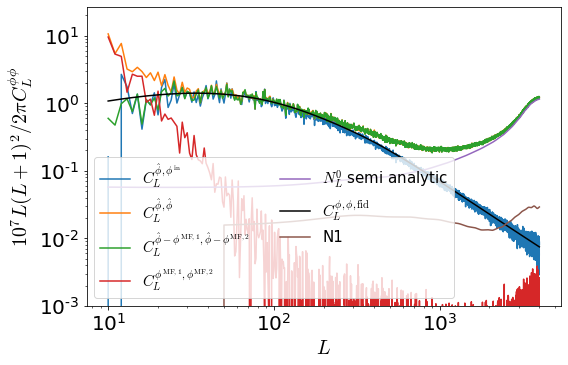

In [36]:
lmax = 4000
ls = np.arange(10, lmax+1)

pl.plot(ls, w(ls)*hp.alm2cl(plm0, plm_in, lmax_out=lmax)[ls]/fsky, label=r'$C_L^{\hat \phi, \phi^{\rm in}}$')
pl.plot(ls, w(ls)*hp.alm2cl(plm0, plm0, lmax_out=lmax)[ls]/fsky, label=r'$C_L^{\hat \phi, \hat \phi}$')
pl.plot(ls, w(ls)*hp.alm2cl(plm0-plm_mf1, plm0-plm_mf2, lmax_out=lmax)[ls]/fsky, label=r'$C_L^{\hat \phi -\phi^{\rm MF, 1}, \hat \phi-\phi^{\rm MF, 2}}$')


pl.plot(ls, w(ls)*hp.alm2cl(plm_mf1, plm_mf2, lmax_out=lmax)[ls]/fsky, label=r'$C_L^{\phi^{\rm MF, 1},\phi^{\rm MF, 2}}$')

# pl.plot(ls, w(ls)*hp.alm2cl((plm_mf1+plm_mf2)/2., lmax_out=lmax)[ls]/fsky, label=r'$C_L^{\phi^{\rm MF}, \hat \phi-\phi^{\rm MF}}$')

# pl.plot(ls, w(ls)*utils.cli(resp)[ls])
pl.plot(ls, w(ls)*N0[ls], label='$N_L^0$ semi analytic')
pl.plot(ls, w(ls)*param_file.cls_unl['pp'][ls], c='k', label=r"$C_L^{\phi, \phi, \rm fid}$")

pl.plot(ls, w(ls)*N1[ls], label='N1')

pl.loglog()

pl.legend(fontsize=15, ncol=2, loc=3)
pl.ylim(ymin=1e-3)

pl.xlabel(r'$L$')
pl.ylabel(r'$ 10^7 L(L+1)^2 / 2\pi C_L^{\phi\phi}$')

Text(0, 0.5, '$\\Delta C_L^{\\hat \\phi, \\hat \\phi} / C_L^{\\phi\\phi, \\rm fid}$')

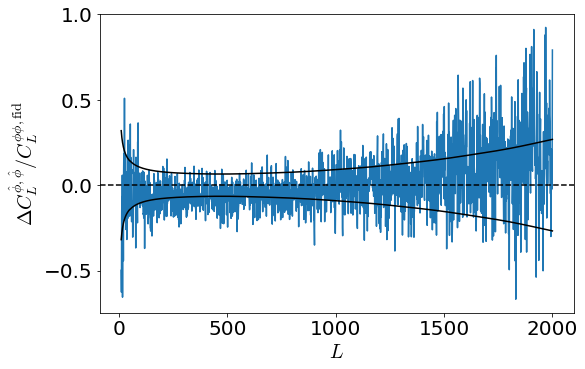

In [32]:
# Lensing power spectrum residual
lmax = 2000
ls = np.arange(10, lmax+1)

cov = utils.cli(2*np.arange(lmax+1)*fsky) * (param_file.cls_unl['pp'][:lmax+1]+N0[:lmax+1]+N1[:lmax+1])**2

pl.plot(ls, (hp.alm2cl(plm0-plm_mf1, plm0-plm_mf2, lmax_out=lmax)[ls]/fsky - N0[ls]-N1[ls])*utils.cli(param_file.cls_unl['pp'][ls])-1)
# pl.plot(ls, (hp.alm2cl(plm0-plm_mf1, plm0-plm_mf2, lmax_out=lmax)[ls]/fsky - N0[ls]-N1[ls])*utils.cli(param_file.cls_unl['pp'][ls])-1)
# pl.plot(ls, (hp.alm2cl(plm0, plm0, lmax_out=lmax)[ls]/fsky - N0[ls]-N1[ls])*utils.cli(param_file.cls_unl['pp'][ls]))
# pl.plot(ls, (hp.alm2cl(plm0-plm_mf1, plm0-plm_mf2, lmax_out=lmax)[ls]/fsky - N0[ls]-N1[ls])*utils.cli(hp.alm2cl(plm_in, plm_in, lmax_out=lmax)[ls])-1)


# pl.plot(ls, (hp.alm2cl(plm0, plm_in, lmax_out=lmax)[ls]/fsky)*utils.cli(param_file.cls_unl['pp'][ls]))

pl.plot(ls, np.sqrt(cov)[ls]*utils.cli(param_file.cls_unl['pp'][ls]), c='k')
pl.plot(ls, -np.sqrt(cov)[ls]*utils.cli(param_file.cls_unl['pp'][ls]), c='k')

pl.axhline(y=0, c='k', ls='--')

pl.xlabel('$L$')
pl.ylabel(r'$\Delta C_L^{\hat \phi, \hat \phi} / C_L^{\phi\phi, \rm fid}$')

# Plot convergence map


In [30]:
wf = param_file.cls_unl['pp'][:4001]*utils.cli(param_file.cls_unl['pp'][:4001] + N0[:4001])

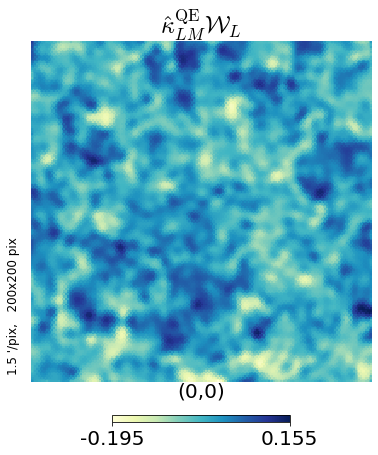

In [31]:
klm = hp.almxfl(plm0 - (plm_mf1+plm_mf2)/2., p2k(lmax)*wf[:lmax+1])

hp.gnomview(hp.alm2map(klm, nside=2048), cmap='YlGnBu', title=r'$\hat \kappa^{\rm QE}_{LM} \mathcal{W}_L$')

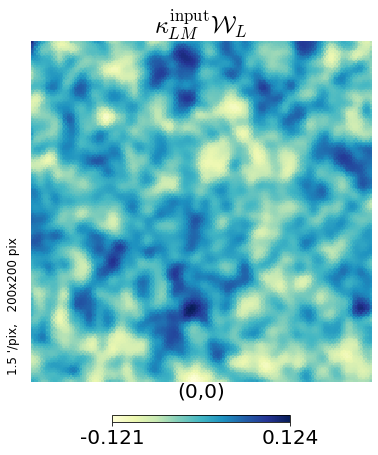

In [32]:
klm_in = hp.almxfl(plm_in, p2k(lmax)*wf[:lmax+1])
hp.gnomview(hp.alm2map(klm_in, nside=2048), cmap='YlGnBu',  title=r'$ \kappa^{\rm input}_{LM} \mathcal{W}_L$')

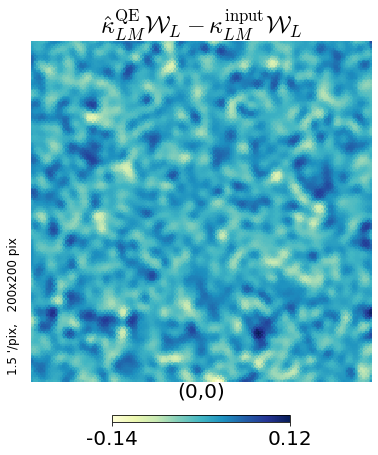

In [33]:
hp.gnomview(hp.alm2map(klm-klm_in, nside=2048), cmap='YlGnBu', title=r'$\hat \kappa^{\rm QE}_{LM} \mathcal{W}_L -\kappa^{\rm input}_{LM} \mathcal{W}_L$')

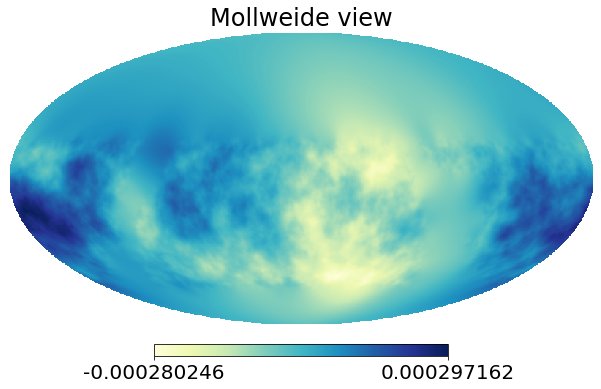

In [34]:
hp.mollview(hp.alm2map(plm0 - (plm_mf1+plm_mf2)/2., nside=2048), cmap='YlGnBu')

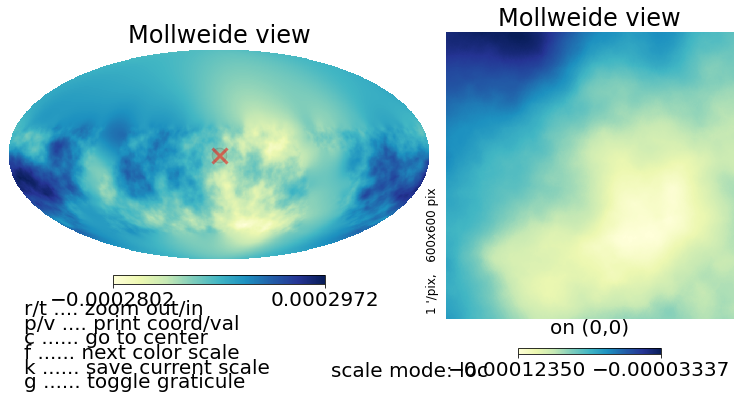

In [35]:
hp.mollzoom(hp.alm2map(plm0 - (plm_mf1+plm_mf2)/2., nside=2048), cmap='YlGnBu')